# Kernel Functions Profiling

This notebook is there to show how to do some simple function profiling using LISA.

We'll be using the Ftrace function profiler (See "Function profiling" in https://lwn.net/Articles/370423/) for that, and will present the relevant Python APIs from Devlib & LISA that make it easier to use.

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2018-12-06 12:06:06,453 INFO    : root         : Using LISA logging configuration:
2018-12-06 12:06:06,454 INFO    : root         :   /data/work/lisa/logging.conf


In [2]:
import os
from lisa.env import TestEnv, TargetConf

2018-12-06 12:06:06,478 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2018-12-06 12:06:06,502 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


## Target configuration

The only target requirement here is to have enough Ftrace goodies enabled (look at the requirements for **CONFIG_FUNCTION_PROFILER**)

In [3]:
target_conf = TargetConf({
    "kind" : "linux",
    "name" : "hikey960",
    
    "host": "192.168.0.1",
    "username" : "root",
    "password" : "root"
})

In [4]:
te = TestEnv(target_conf)
target = te.target

2018-12-06 12:06:07,215 INFO    : lisa.env.TestEnv : Target configuration:
|- username from user (str): root
|- name from user (str): hikey960
|- kind from user (str): linux
|- host from user (str): 192.168.0.1
|- password from user (str): root
+- devlib:
    +- platform:
        |- class from default (str): devlib.platform.Platform
+- ftrace:
    |- buffsize from default (int): 10240
2018-12-06 12:06:07,282 INFO    : lisa.env.TestEnv : User-defined platform information:
|- name from target-conf (str): hikey960
2018-12-06 12:06:07,315 INFO    : lisa.env.TestEnv : linux hikey960 target connection settings:
2018-12-06 12:06:07,316 INFO    : lisa.env.TestEnv :   username : root
2018-12-06 12:06:07,317 INFO    : lisa.env.TestEnv :   password : root
2018-12-06 12:06:07,318 INFO    : lisa.env.TestEnv :       host : 192.168.0.1
2018-12-06 12:06:07,318 INFO    : lisa.env.TestEnv :       port : 22
2018-12-06 12:06:07,335 INFO    : lisa.env.TestEnv : Devlib modules to load: bl, cgroups, cpufreq,

## Experiment setup

We can run whatever we want here, let's just build a simple ((1 20% task) x NR_CPUS) workload

In [5]:
from lisa.wlgen.rta import RTA, Periodic

In [6]:
rtapp_profile = {}

for cpu in range(target.number_of_cpus):
    rtapp_profile["task{}".format(cpu)] = Periodic(duty_cycle_pct=20)

In [7]:
wload = RTA.by_profile(te, "profiling_wload", rtapp_profile)

2018-12-06 12:06:26,283 INFO    : lisa.env.TestEnv : Creating result directory: /data/work/lisa/results/hikey960-20181206_120607.215627/profiling_wload-20181206_120626.282417
2018-12-06 12:06:36,702 INFO    : lisa.env.TestEnv : Creating result directory: /data/work/lisa/results/hikey960-20181206_120607.215627/rta_calib-20181206_120636.701911
2018-12-06 12:06:36,865 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2018-12-06 12:06:37,190 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2018-12-06 12:06:37,192 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2018-12-06 12:06:37,193 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-06 12:06:37,195 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2018-12-06 12:06:37,196 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-06 12:06:37,198 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-12-06 12:06:37,199 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-12-06 12:

2018-12-06 12:07:46,546 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-06 12:07:46,547 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2018-12-06 12:07:46,548 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-06 12:07:46,548 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-12-06 12:07:46,549 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-12-06 12:07:46,549 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2018-12-06 12:07:46,550 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2018-12-06 12:07:46,551 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2018-12-06 12:07:46,551 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-06 12:07:46,552 INFO    : lisa.wlgen.rta.RTA : task [task2], sched: using default policy
2018-12-06 12:07:46,552 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-06 12:07:46,553 INFO    : l

Now, let's define the functions we want to do some profiling on. Do keep in mind all functions might not be profilable - that can happen if they are inline.

In [8]:
functions = [
    "scheduler_tick",
    "run_rebalance_domains"
]

We're using an FtraceCollector so might as well record some basic events to get a meaningful trace

In [9]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new"
]

## Running the experiment

In [10]:
from devlib.trace.ftrace import FtraceCollector

In [11]:
ftrace = FtraceCollector(target, functions=functions, buffer_size=10240)

with ftrace:
    wload.run()

# Save the trace
ftrace.get_trace(os.path.join(wload.res_dir, "trace.dat"))
# Save the profiling stats
ftrace.get_stats(os.path.join(wload.res_dir, "stats.json"))

2018-12-06 12:07:54,600 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-target/bin/rt-app /root/devlib-target/profiling_wload.json 2>&1
2018-12-06 12:07:55,786 INFO    : lisa.wlgen.rta.RTA : Execution complete


{0: {'run_rebalance_domains': {'avg': 28.565,
   'hits': 129,
   's_2': 838.923,
   'time': 3684.901},
  'scheduler_tick': {'avg': 17.795,
   'hits': 179,
   's_2': 199.158,
   'time': 3185.424}},
 1: {'run_rebalance_domains': {'avg': 15.449,
   'hits': 83,
   's_2': 53.21,
   'time': 1282.29},
  'scheduler_tick': {'avg': 20.458,
   'hits': 210,
   's_2': 205.694,
   'time': 4296.366}},
 2: {'run_rebalance_domains': {'avg': 26.185,
   'hits': 315,
   's_2': 625.211,
   'time': 8248.431},
  'scheduler_tick': {'avg': 8.81, 'hits': 372, 's_2': 92.7, 'time': 3277.608}},
 3: {'run_rebalance_domains': {'avg': 15.117,
   'hits': 38,
   's_2': 48.512,
   'time': 574.479},
  'scheduler_tick': {'avg': 16.695,
   'hits': 182,
   's_2': 144.725,
   'time': 3038.539}},
 4: {'run_rebalance_domains': {'avg': 10.529,
   'hits': 69,
   's_2': 69.795,
   'time': 726.567},
  'scheduler_tick': {'avg': 8.895,
   'hits': 203,
   's_2': 23.236,
   'time': 1805.732}},
 5: {'run_rebalance_domains': {'avg': 13.

In [12]:
!tree {wload.res_dir}

/data/work/lisa/results/hikey960-20181206_120607.215627/profiling_wload-20181206_120626.282417
├── output.log
├── profiling_wload.json
├── rt-app-cpu0_task0-6.log
├── rt-app-cpu0_task0-9.log
├── rt-app-cpu0_task1-17.log
├── rt-app-cpu0_task1-9.log
├── rt-app-cpu0_task2-21.log
├── rt-app-cpu0_task2-4.log
├── rt-app-cpu1_task0-14.log
├── rt-app-cpu1_task0-2.log
├── rt-app-cpu1_task1-4.log
├── rt-app-cpu1_task1-7.log
├── rt-app-cpu1_task2-10.log
├── rt-app-cpu1_task2-15.log
├── rt-app-cpu2_task0-19.log
├── rt-app-cpu2_task0-20.log
├── rt-app-cpu2_task1-10.log
├── rt-app-cpu2_task1-21.log
├── rt-app-cpu2_task2-11.log
├── rt-app-cpu2_task2-12.log
├── rt-app-cpu3_task0-23.log
├── rt-app-cpu3_task0-2.log
├── rt-app-cpu3_task1-17.log
├── rt-app-cpu3_task1-3.log
├── rt-app-cpu3_task2-0.log
├── rt-app-cpu3_task2-13.log
├── rt-app-cpu4_task0-16.log
├── rt-app-cpu4_task0-5.log
├── rt-app-cpu4_task1-11.log
├── rt-app-cpu4_task1-14.log
├── rt-app-cpu4_task2-22.log
├── rt-app-cpu4_task2-7.log
├── rt-

## Loading the trace

In [13]:
from lisa.trace import Trace

In [14]:
trace = Trace(wload.res_dir, te.plat_info, events=events)

We can have a look at the trace of the workload we just ran

In [15]:
from trappy.plotter import plot_trace

In [16]:
plot_trace(trace.ftrace)

## Loading the function profiling

The profiling stats are JSON so let's load it up into a dict

In [17]:
import json

In [18]:
stats_path = os.path.join(wload.res_dir, "stats.json")

with open(stats_path, "r") as fh:
    # That ';' is just there to prevent Jupyter from dumping the dict in stdout
    stats = json.load(fh);

The data in the file is arranged like so:

- For each CPU
    - For each function
       - time (µs)
       - hits (#)
       - s_2, AKA variance - apply sqrt() to get standard deviation
       - avg (µs)
       
To make it a bit simpler to manipulate, we're going to turn this data into a pandas DataFrame.

In [19]:
import pandas as pd

def stats_to_df(stats_dict):
    """
    Turn Ftrace function profiling stats into a pandas DataFtrame
    
    :param stats_dict: The stats dictionnary generated by FtraceCollector
    :type stats_dict: dict
    """
    data = []
    index = []
    
    for cpu, functions in stats_dict.items():
        index.append(int(cpu))
        columns = []
        line = []
        
        for function, stats in functions.items():
            
            for name, stat in stats.items():
                columns.append((function, name))
                line.append(stat)

        data.append(line)
        
    df = pd.DataFrame(data, index=index, columns=columns)
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=["function", "cpu"])
    df = df.sort_index()
    return df

In [20]:
df = stats_to_df(stats)

Here's how the Dataframe looks like:

In [21]:
df

function scheduler_tick                          run_rebalance_domains  \
cpu                 avg      time  hits      s_2                   avg   
0                17.795  3185.424   179  199.158                28.565   
1                20.458  4296.366   210  205.694                15.449   
2                 8.810  3277.608   372   92.700                26.185   
3                16.695  3038.539   182  144.725                15.117   
4                 8.895  1805.732   203   23.236                10.529   
5                 4.333  4740.621  1094   16.143                13.387   
6                 8.917  1765.634   198   22.484                11.078   
7                 8.709  1532.814   176   23.114                10.356   

function                          
cpu           time hits      s_2  
0         3684.901  129  838.923  
1         1282.290   83   53.210  
2         8248.431  315  625.211  
3          574.479   38   48.512  
4          726.567   69   69.795  
5         8634.903  645   78.221  
6          775.514   70   52.650  
7          714.585   69   33.649

We can easily have a look at a specific function:

In [22]:
df.run_rebalance_domains

cpu,avg,time,hits,s_2
0,28.565,3684.901,129,838.923
1,15.449,1282.290,83,53.210
2,26.185,8248.431,315,625.211
3,15.117,574.479,38,48.512
4,10.529,726.567,69,69.795
5,13.387,8634.903,645,78.221
6,11.078,775.514,70,52.650
7,10.356,714.585,69,33.649


It's also easy to get overall stats for one function. For instance, if we want the total number of hits for a function (summing up the number of hits over all CPUs), that can be done like so:

In [23]:
df.run_rebalance_domains.hits.sum()

1418

You can also get stats recorded on a single CPU like so:

In [24]:
df.run_rebalance_domains.loc[2]

cpu
avg       26.185
time    8248.431
hits     315.000
s_2      625.211
Name: 2, dtype: float64

## Visual profiling

Now that we have all of the relevant data in Dataframe format, it's very easy to make plots out of it

In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def plot_hits(df, function):
    fig, ax = plt.subplots(figsize=(16, 5))
    
    df[function].hits.plot.bar(ax=ax)    
    ax.set_title("Per-CPU hits of \"{}\"".format(function))
    ax.set_xlabel("CPU")
    ax.set_ylabel("# of hits")
    ax.grid(True)

In [27]:
def plot_time_avg(df, function):
    fig, ax = plt.subplots(figsize=(16, 5))
    
    # Let's compute the standard deviation to plot error bars
    stddev = df[function].s_2.apply(np.sqrt)
    
    df[function].avg.plot.bar(ax=ax, yerr=stddev, capsize=10)    
    ax.set_title("Per-CPU average time of \"{}\"".format(function))
    ax.set_xlabel("CPU")
    ax.set_ylabel("Average time (µs)")
    ax.grid(True)

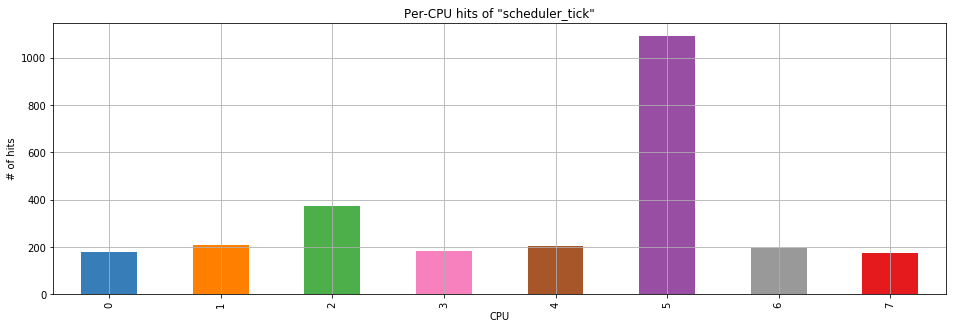

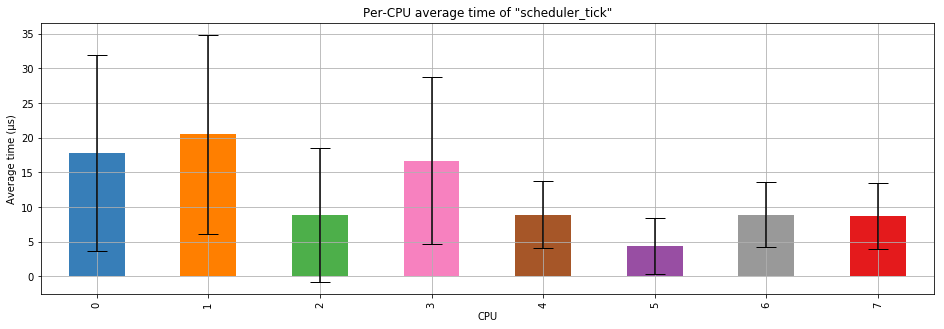

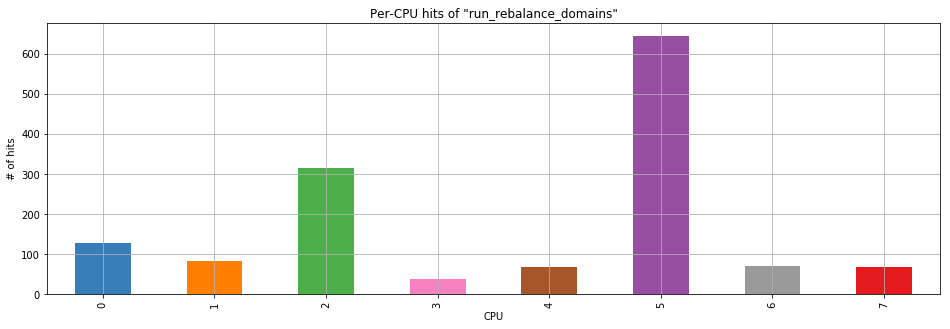

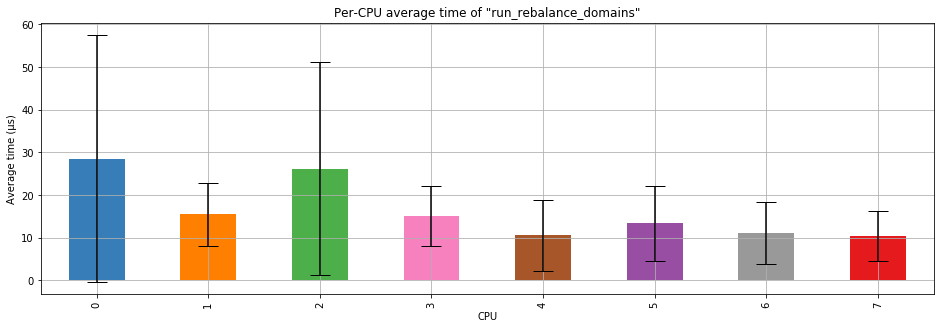

In [28]:
for function in functions:
    plot_hits(df, function)
    plot_time_avg(df, function)